### XGBoost on Escherichia coli

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)

In [2]:
ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_2236/608710242.py:1: DtypeWarning: Columns (530424) have mixed types. Specify dtype option on import or set low_memory=False.
  ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')


In [27]:
ecoli.shape

(600, 530425)

In [3]:
# Separate feature columns and target labels
X = ecoli.drop(columns=['TMP',"CTX","SUL","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
ecoli_tmp = X.copy()
ecoli_tmp['label'] = ecoli['TMP']
y_tmp = ecoli_tmp['label']

ecoli_ctx = X.copy()
ecoli_ctx['label'] = ecoli['CTX']
y_ctx = ecoli_ctx['label']

ecoli_sul = X.copy()
ecoli_sul['label'] = ecoli['SUL']
y_sul = ecoli_sul['label']

In [4]:
# Train-test split
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X, y_tmp, stratify= y_tmp, test_size=0.3, random_state=42)

X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X, y_ctx, stratify= y_ctx, test_size=0.3, random_state=42)

X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X, y_sul, stratify= y_sul, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_tmp, y_train_resampled_tmp = smote.fit_resample(X_train_tmp, y_train_tmp)
X_train_resampled_ctx, y_train_resampled_ctx = smote.fit_resample(X_train_ctx, y_train_ctx) 

print("TMP Resampled Class Distribution:", Counter(y_train_resampled_tmp))
print("CTX Resampled Class Distribution:", Counter(y_train_resampled_ctx))

TMP Resampled Class Distribution: Counter({0: 228, 1: 228})
CTX Resampled Class Distribution: Counter({1: 311, 0: 311})


### Blocked cross-validation

In [5]:
hparam = {"eta":[0.1, 0.2, 0.4, 0.8]}

In [6]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tmp = X_train_resampled_tmp['ST'].values
X_train_input_tmp = X_train_resampled_tmp.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_sul = X_train_sul['ST'].values
X_train_input_sul = X_train_sul.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_ctx = X_train_resampled_ctx['ST'].values
X_train_input_ctx = X_train_resampled_ctx.drop(columns=['ST'])

##### 1. TMP

In [7]:
model_tmp = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tmp, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tmp, y_train_resampled_tmp, groups=groups_tmp, verbose=0)
params_tmp = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9561
Best Parameters: {'eta': 0.4}


##### 2. SUL

In [8]:
model_sul = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_sul, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_sul, y_train_sul, groups=groups_sul, verbose=0)
params_sul = grid_result.best_params_
best_model_sul = grid_result.best_estimator_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9771
Best Parameters: {'eta': 0.1}


##### 3. CTX

In [9]:
model_ctx = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_ctx, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_ctx, y_train_resampled_ctx, groups=groups_ctx, verbose=0)
params_ctx = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.7824
Best Parameters: {'eta': 0.8}


### Training with best hyperparameters and testing

In [10]:
def run_GB(X_train, y_train, params):
  GB =  XGBClassifier(random_state = 42, eta=params['eta'])
  # Training XGB Classifier model
  GB = GB.fit(X_train, y_train)
  # Checking number of trees in the model
  print("Number of Decicion Trees in XGB Classifier model:", GB.get_booster().trees_to_dataframe().shape[0]
)
  return GB

In [20]:
def evaluate(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification XGBoost model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained XGBoost model
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction
    """
    # Predict probabilities
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Classification report (per class)
    report = classification_report(
        y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True
    )

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for XGBoost model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost model of {}'.format(model_name))
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve for XGBoost model of {}".format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"]))

In [12]:
# Separate feature columns and target labels
X = ecoli.drop(columns=['TMP',"CTX","SUL","sample_ID", 'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
ecoli_tmp = X.copy()
ecoli_tmp['label'] = ecoli['TMP']
y_tmp = ecoli_tmp['label']

ecoli_ctx = X.copy()
ecoli_ctx['label'] = ecoli['CTX']
y_ctx = ecoli_ctx['label']

ecoli_sul = X.copy()
ecoli_sul['label'] = ecoli['SUL']
y_sul = ecoli_sul['label']

# Train-test split
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X, y_tmp, stratify= y_tmp, test_size=0.3, random_state=42)

X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X, y_ctx, stratify= y_ctx, test_size=0.3, random_state=42)

X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X, y_sul, stratify= y_sul, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_tmp, y_train_resampled_tmp = smote.fit_resample(X_train_tmp, y_train_tmp)
X_train_resampled_ctx, y_train_resampled_ctx = smote.fit_resample(X_train_ctx, y_train_ctx) 

print("TMP Resampled Class Distribution:", Counter(y_train_resampled_tmp))
print("SUL Class Distribution:", Counter(y_train_sul))
print("CTX Resampled Class Distribution:", Counter(y_train_resampled_ctx))

TMP Resampled Class Distribution: Counter({0: 244, 1: 244})
SUL Class Distribution: Counter({0: 223, 1: 197})
CTX Resampled Class Distribution: Counter({0: 330, 1: 330})


##### 1. TMP

Number of Decicion Trees in XGB Classifier model: 556


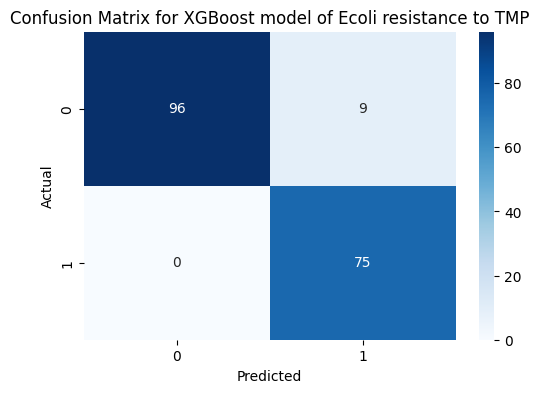

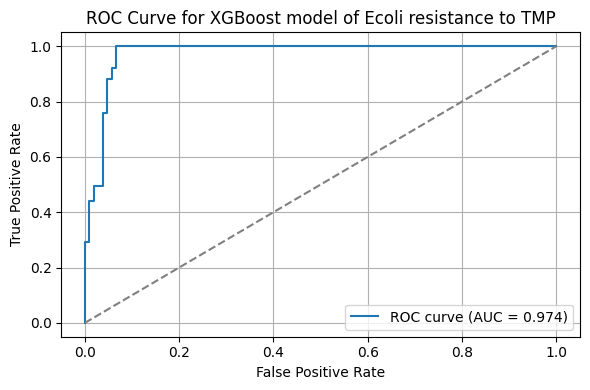

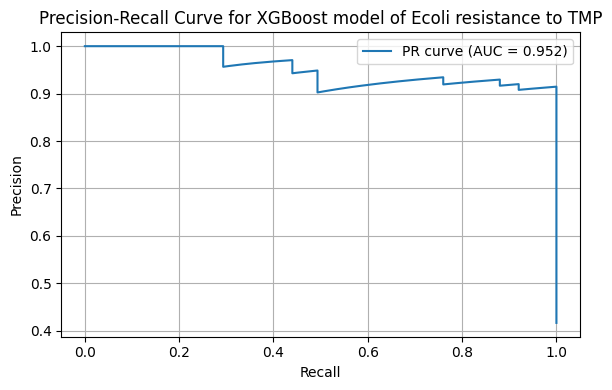

Training Accuracy: 1.0000
Test Accuracy:     0.9500
Overall Precision: 0.8929
Overall Recall:    1.0000
Overall F1 Score:  0.9434
ROC AUC:           0.9741

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.91 | F1: 0.96
Resistant    | Precision: 0.89 | Recall: 1.00 | F1: 0.94

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      0.91      0.96       105
   Resistant       0.89      1.00      0.94        75

    accuracy                           0.95       180
   macro avg       0.95      0.96      0.95       180
weighted avg       0.96      0.95      0.95       180



In [21]:
model_tmp = run_GB(X_train_resampled_tmp, y_train_resampled_tmp, params_tmp)
evaluate(model_tmp, X_train_resampled_tmp, y_train_resampled_tmp, X_test_tmp, y_test_tmp, model_name="Ecoli resistance to TMP")

##### 2. SUL

Number of Decicion Trees in XGB Classifier model: 838


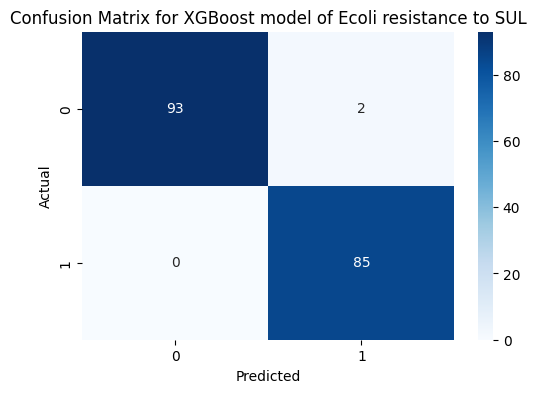

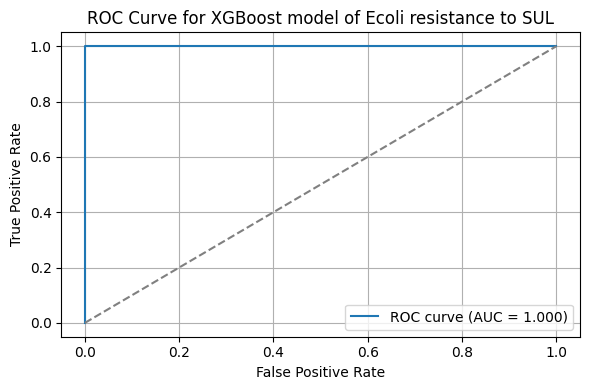

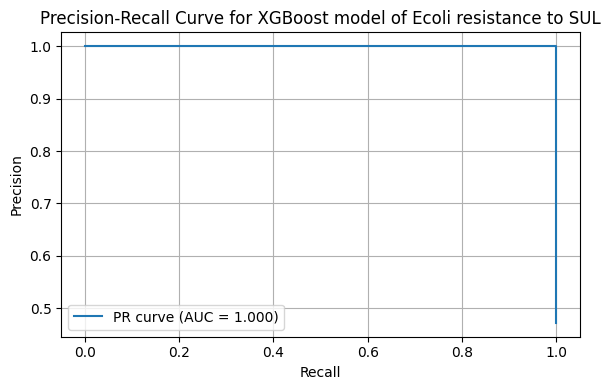

Training Accuracy: 1.0000
Test Accuracy:     0.9889
Overall Precision: 0.9770
Overall Recall:    1.0000
Overall F1 Score:  0.9884
ROC AUC:           1.0000

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.98 | F1: 0.99
Resistant    | Precision: 0.98 | Recall: 1.00 | F1: 0.99

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      0.98      0.99        95
   Resistant       0.98      1.00      0.99        85

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [22]:
model_sul = run_GB(X_train_sul, y_train_sul, params_sul)
evaluate(model_sul, X_train_sul, y_train_sul, X_test_sul, y_test_sul, model_name="Ecoli resistance to SUL")

##### 3. CTX

Number of Decicion Trees in XGB Classifier model: 292


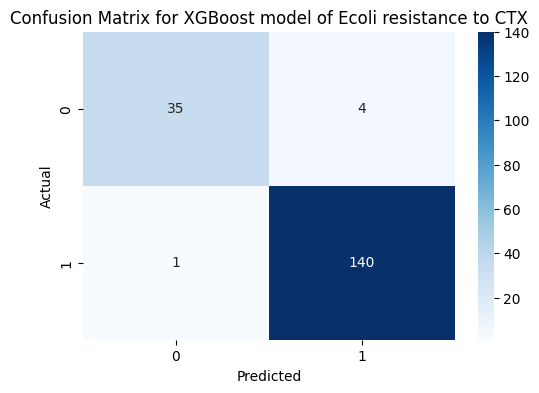

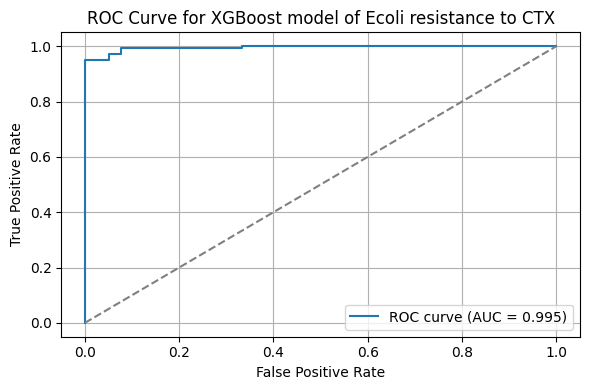

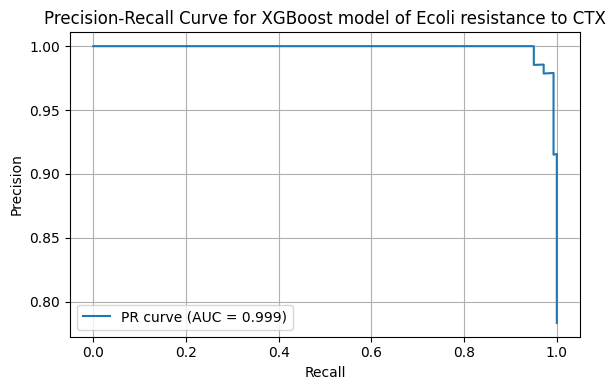

Training Accuracy: 1.0000
Test Accuracy:     0.9722
Overall Precision: 0.9722
Overall Recall:    0.9929
Overall F1 Score:  0.9825
ROC AUC:           0.9949

Per-Class Performance:
Susceptible  | Precision: 0.97 | Recall: 0.90 | F1: 0.93
Resistant    | Precision: 0.97 | Recall: 0.99 | F1: 0.98

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       0.97      0.90      0.93        39
   Resistant       0.97      0.99      0.98       141

    accuracy                           0.97       180
   macro avg       0.97      0.95      0.96       180
weighted avg       0.97      0.97      0.97       180



In [23]:
model_ctx = run_GB(X_train_resampled_ctx, y_train_resampled_ctx, params_ctx)
evaluate(model_ctx, X_train_resampled_ctx, y_train_resampled_ctx, X_test_ctx, y_test_ctx, model_name="Ecoli resistance to CTX")

### Feature importance

##### 1. TMP

In [24]:
booster_tmp = model_tmp.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_tmp.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
xerC_7~~~xerC_2~~~xerC_9~~~xerC_5~~~xerC_6~~~xerD_2~~~xerD_4~~~xerC_4~~~xerC_3~~~xerC_10~~~xerC_8: 49.6737
SNP_30497: 7.5976
SNP_10945: 7.3405
yokD: 7.2994
ant1~~~ant1_1~~~ant1_2: 5.5954
SNP_211839: 4.6809
SNP_386188: 4.1946
dhfrI_2~~~dhfrI: 3.8119
group_7843: 3.7079
group_5068: 3.6704
SNP_70408: 3.5626
SNP_374858: 3.4492
SNP_255316: 3.1931
rfbA~~~rmlA~~~rfbA_1: 2.9234
group_14444: 2.8680
SNP_498177: 2.6865
SNP_313405: 2.5440
ermD: 2.5281
SNP_113260: 2.3921
folP_2~~~folP_3~~~sulA_2~~~folP_5: 2.3255


##### 2. SUL

In [25]:
booster_sul = model_sul.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_sul.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
xerC_7~~~xerC_2~~~xerC_9~~~xerC_5~~~xerC_6~~~xerD_2~~~xerD_4~~~xerC_4~~~xerC_3~~~xerC_10~~~xerC_8: 70.5672
folP_2~~~folP_3~~~sulA_2~~~folP_5: 13.6678
SNP_220459: 6.7422
ant1~~~ant1_1~~~ant1_2: 6.0193
group_14282: 5.4868
group_13942: 5.2925
group_4216: 5.0465
group_14713: 4.9573
SNP_484835: 4.7708
SNP_484691: 4.7247
group_1603: 4.2106
SNP_143134: 4.1685
group_14373: 4.0888
SNP_86693: 4.0777
emrE~~~mdtI_2~~~qacC~~~mmr~~~folP1~~~mdtJ_1: 3.9918
SNP_218917: 3.9713
SNP_286741: 3.7645
SNP_62344: 3.2561
group_13782: 3.1900
SNP_234254: 2.8858


##### 3. CTX

In [26]:
booster_ctx = model_ctx.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_ctx.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
SNP_351032: 186.6480
SNP_460759: 71.9816
SNP_18342: 65.0801
SNP_156222: 28.7044
SNP_108136: 23.3501
group_19469: 15.9250
SNP_460803: 14.6801
group_6960: 14.6251
SNP_403722: 8.7476
SNP_249398: 8.2388
SNP_34669: 8.0820
noc~~~spo0C~~~noc_1~~~noc_3~~~noc_2: 7.8000
SNP_120787: 7.1530
SNP_442759: 7.0767
SNP_66247: 6.9823
SNP_11795: 4.8157
SNP_406741: 4.1300
group_12770: 3.7462
group_13747: 3.6000
bla_3~~~bla_4~~~bla~~~bla_2~~~bla_1: 2.8455
